# Preprocessing & Calculate FCS and HDDS From Household Survey Data Of Rwanda

In this Python notebook, we will explore the process of preprocessing household survey data from Rwanda to compute two food security indicators: **Food Consumption Score (FCS)** and **Household Dietary Diversity Score (HDDS)**. These indicators play a crucial role in assessing food security and nutritional status at the household level. The aim of calculating these indicators is to use them as ground truth data in the research project of using machine learning and deep learning for prediction for security indicators(FCS and HDDS) from heterogenous data.


### Food Security Indicators
    
These are quantitative measures used to evaluate the accessibility, availability, and utilization of food at various levels starting from households,community to the national level. These indicators provide insights into the extent and severity of food insecurity, helping policymakers, researchers, and practitioners to identify vulnerable populations and design targeted interventions. There are numbers of food security indicators however as we mentioned early we will only focus on two indicators which are **Food Consumption Score(FCS)** and **Household Dietary Diversity Score(HDDS)**. The details description of these indicators will be given to the [Computation of FCS and HDDS](#compute_fcs_hdds) section.
    


### About Rwanda
Rwanda is a small landlocked country located in the heart of East Africa. Bordered by Uganda to the north, Tanzania to the east, Burundi to the south, and the Democratic Republic of the Congo to the west. Agriculture forms the backbone of Rwanda's economy, employing a large portion of the population and contributing significantly to GDP.The country is vulnerable to climate change, experiencing erratic rainfall patterns, prolonged droughts, and extreme weather events. These environmental factors disrupt agricultural productivity, leading to crop failures and food shortages.

### Data Source

We will be working with household survey data from Rwanda which consists of 6 datasets collected from [National Institute of Statistics of Rwanda (NISR)](http://microdata.statistics.gov.rw)
. These datasets contains information on various household characteristics, including food consumption, dietary habits, demographic details, and socio-economic factors.However for our task we will only focus with information concerning food consumption and their spatial distribution.

#### These 6 datasets are includes:

* [2006 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/26)

* [2009 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/8)

* [2012 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/69)

* [2015 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/70)

* [2018 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/91)

* [2021 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/106)

## Import Libraries

In this section, we import essential libraries and modules required for data preprocessing, analysis, and visualization tasks. These libraries provide robust functionalities and tools that streamline the data analysis workflow and enable us to manipulate and explore the dataset efficiently.

In [1]:
#uncomment to install savReaderWriter
#!pip install savReaderWriter
!pip install pandas pyreadstat savReaderWriter numpy seaborn folium geopandas matplotlib plotly ipywidgets branca


In [54]:
import pandas as pd
import pyreadstat as ps
from pandas import read_csv
import savReaderWriter as sv
import numpy as np
import seaborn as sns
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from ipywidgets import interact, IntSlider
from branca.colormap import LinearColormap

## <a id='helper_function'></a> Helper Function

In this section we define a set of helper functions designed to streamline data preprocessing tasks and facilitate the computation of Food Consumption Score (FCS) and Household Dietary Diversity Score (HDDS). These functions are designed to assist in converting dataset files from different formats to a common format (i.e., .csv), making them compatible with various data analysis tools and workflows.

In [3]:
def decode_value(value):
    
    '''
    This function decodes bytes to string and handles integer values.
    It checks if the input value is a bytes object and decodes it to a UTF-8 encoded string.
    If the value is a float and represents an integer, it converts it to an integer.
    Otherwise, it returns the original value.
    It is important while converting the .sav file to .csv.
    '''
    
    if isinstance(value, bytes):
        return value.decode('utf-8')
    elif isinstance(value, float) and value.is_integer():
        return int(value)
    else:
        return value

In [4]:
def sav_to_csv(sav_path,csv_path):
    
    '''
    This function converts a .sav (SPSS) file to a .csv (comma-separated values) file.
    It reads the .sav file using sv.SavReader, extracts column names, and decodes values using the decode_value function.
    The data is then converted to a DataFrame and saved as a .csv file at the specified path.
    '''
    
    with sv.SavReader(sav_path) as reader:
        # Extract the column names
        column_names = [name.decode('utf-8') for name in reader.header]
        
        # Read the data and decode values
        data = [[decode_value(value) for value in row] for row in reader]
    
    df = pd.DataFrame(data, columns=column_names)
    df.to_csv(csv_path, index=False)
    print(f"A new dataset is saved to {csv_path}")

In [5]:
def dta_to_csv(dta_path, csv_path):
    
    '''
    This function converts a .dta (Stata) file to a .csv file.
    It reads the .dta file using pd.read_stata and loads it into a DataFrame.
    The DataFrame is then saved as a .csv file at the specified path
    '''
    
    df = pd.read_stata(dta_path)
    df.to_csv(csv_path, index=False)
    print(f"A new dataset is saved to {csv_path}")

In [6]:
def subset_and_save(df, columns_to_keep, output_file, year, rename_columns=None):
    
    '''
    This function is designed to subset a DataFrame based on specified columns, add a year column
    and save the resulting subset to a new CSV file. 
    This function is helful when your dataset have a large number of columns and you only need to work with some of them.
    
    Parameters:
        df (DataFrame): The original DataFrame.
        columns_to_keep (list): A list of column names to keep.
        output_file (str): The path to the output CSV file.
        year(int): The year associated with the dataset, which will be added as a new column.
        rename_columns (dict, optional): A dictionary where keys are original column names and values are new names.
    '''
    
    # Selecting columns to keep
    df_subset = df[columns_to_keep]

    # Optionally renaming columns
    if rename_columns:
        df_subset = df_subset.rename(columns=rename_columns)
    
    # Adding a year column
    df_subset.insert(0, 'year', year)

    # Save the subset DataFrame to a new CSV file
    df_subset.to_csv(output_file, index=False)

    print(f"A new dataset is saved to {output_file}")

In [24]:
def delete_columns(dataframe, columns_to_delete):
    dataframe_copy = dataframe.copy()  # Make a copy to avoid modifying the original dataframe
    deleted_columns = []
    for column in columns_to_delete:
        if column in dataframe_copy.columns:
            dataframe_copy.drop(column, axis=1, inplace=True)
            deleted_columns.append(column)
        else:
            print(f"Column '{column}' not found in dataframe.")
    if deleted_columns:
        print("Deleted columns:", deleted_columns)
    else:
        print("No columns were deleted.")
    return dataframe_copy

In [137]:
def merge_data(df_loc,df_fcs,df_hdds):
    '''
    Merge three data frames based on 'hhid' column using left join.

    Parameters:
        df_loc (DataFrame): First data frame containing the address of the household.
        df_fcs (DataFrame): Second data frame containing the fcs.
        df_hdds (DataFrame): Third data frame containing the hdds.

    Returns:
        DataFrame: Merged data frame.
    '''

    # Merge based on 'hhid' column
    merged_df = pd.merge(df_fcs, df_loc[['hhid','year','province','district', 'zone']], on='hhid', how='left')
    #merged_df = pd.merge(df_fcs, df_loc[['hhid','year','province','district', 'sector']], on='hhid', how='left')
    merged_df = pd.merge(merged_df, df_hdds[['hhid', 'hdds']], on='hhid', how='left')

    # Reorder columns
    merged_df = merged_df[['year', 'hhid', 'province', 'district','zone', 'fcs', 'hdds']]
    #merged_df = merged_df[['year', 'hhid', 'province', 'district','sector', 'fcs', 'hdds']]

    return merged_df

In [8]:
def concatenate_data(*dataframes):
    
    '''
    Concatenate multiple DataFrames provided by the user.

    Parameters:
    *dataframes (DataFrame): Variable number of DataFrame objects.

    Returns:
    DataFrame: Concatenated DataFrame.
    
    '''
    concatenated_df = pd.concat(dataframes)
    return concatenated_df

##### Sanity Check Function
A sanity check is aimed to remove all the household with **0** value in all food groups, we are doing this to prevent the biasing of the food consumption score upon aggregating them on a district and region level. Our assumption here is that it is impossible for a person to not eat anything for the past 7 days.

In [9]:
def sanity_check(df, columns):
    
    ''''
    Check if all specified columns in the dataframe have a value of 0.
    If so, drop those rows permanently and inform the user about the number of deleted rows.

    Parameters:
    - df: DataFrame to be checked
    - columns: List of column names to be checked for zero values

    Returns:
    - None
    
    '''
    # Check if all specified columns have value 0
    mask = df[columns].eq(0).all(axis=1)
    
    # Count number of rows to be deleted
    num_deleted_rows = mask.sum()
    
    if num_deleted_rows > 0:
        # Drop rows where all specified columns have value 0
        df.drop(df[mask].index, inplace=True)
        print(f"{num_deleted_rows} row(s) with all specified columns being 0 have been deleted.")
    else:
        print("No rows have been deleted.")

## Visualization Function

In this section of the notebook, we are creating variety of visualization functions that will effectively illustrate and explore the underlying data. These visualizations will offer insightful perspectives on the dataset, enabling clear interpretation and analysis of our data visually by examining trends, distributions,correlation and spatial relationships. We will create basic plots like histograms and scatter plots to more advanced visualizations such as heatmaps and interactive charts.....

In [10]:
def plot_food_consumption(df,year=None, save_path=None):
    
    '''
    Plots the dietary patterns by food consumption score.

    Parameters:
    - df (pd.DataFrame): DataFrame containing columns for food consumption score ('fcs') 
                         and consumption frequency of different food groups.
    - year (str or int, optional): Year to be added to the plot title.
    - save_path (str, optional): Path to save the plot image. If None, the plot will be displayed but not saved.                     

    Returns:
    - None
    
    '''
    
    # Sort the dataframe by 'fcs' if not already sorted
    df.sort_values('fcs', inplace=True)
    
#     plt.figure(figsize=(30,40))

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.stackplot(df['fcs'], df[['animal_protein', 'cereals_tubers',
                             'dairy_products', 'fruits', 'oil', 'pulses_nuts', 
                             'sugar', 'vegetables_leaves']].T,
             labels=['Animal Protein', 'Cereals & Tubers','Dairy Products',
                     'Fruits', 'Oil', 'Pulses & Nuts', 
                     'Sugar', 'Vegetables & Leaves'])

    # Customize the plot
    ax.legend(loc='upper left')
    title = 'Dietary Patterns by Food Consumption Score'
    if year:
        title += f' {year}'
    ax.set_title(title)
    ax.set_xlabel('FCS')
    ax.set_ylabel('Comulative Consumption Frequency')
    
    max_fcs = max(df['fcs'])
    ax.set_xticks([x for x in range(0, int(max_fcs) + 1, 10) if x <= max_fcs])
    
    # Save the plot
    if save_path:
        plt.savefig(save_path)
    
    # Display the plot
    plt.show()

In [11]:
def visualize_fcs_with_oil_sugar(df, year=None, save_path=None):
    
    ''''
    Visualize the relationship between sugar and oil consumption with respect to FCS.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the relevant columns.
    - year (int or str, optional): Year to include in the title. Default is None.
    - save_path (str, optional): Path to save the plot. Default is None.

    Returns:
    - None
    '''
    # Group by FCS and calculate the mean sugar and oil consumption
    fcs_avg = df.groupby('fcs')[['sugar', 'oil']].mean().reset_index()
    
    # Plot the relationship
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=fcs_avg, x='fcs', y='sugar', label='Sugar')
    sns.lineplot(data=fcs_avg, x='fcs', y='oil', label='Oil')
    
    # Set labels and title
    plt.xlabel('FCS')
    plt.ylabel('Average Consumption')
    
    # Include year in the title if provided
    if year:
        plt.title(f'The Consumption of Sugar and Oil with Respect to FCS - {year}')
    else:
        plt.title('The Consumption of Sugar and Oil with Respect to FCS')  
    
    # Add legend
    plt.legend()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [12]:
def calculate_fcs_percentages(dataframe, year=None, save_path=None):
    
    '''
    Calculate the percentages of households falling into different FCS categories and visualize the distribution.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing FCS data.
    - year (int or str, optional): Year to include in the title. Default is None.
    - save_path (str, optional): Path to save the plot. Default is None.

    Returns:
    - None
    
    '''
    # Calculate the number of households falling into each category
    poor_count = len(dataframe[dataframe['fcs'] <= 21])
    borderline_count = len(dataframe[(dataframe['fcs'] > 21) & (dataframe['fcs'] <= 35)])
    acceptance_count = len(dataframe[dataframe['fcs'] > 35])

    # Calculate percentages
    total_households = len(dataframe)
    poor_percentage = (poor_count / total_households) * 100
    borderline_percentage = (borderline_count / total_households) * 100
    acceptance_percentage = (acceptance_count / total_households) * 100

    # Plot pie chart
    labels = ['Poor', 'Borderline', 'Acceptance']
    sizes = [poor_percentage, borderline_percentage, acceptance_percentage]
    colors = ['red', 'orange', 'green']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    if year:
        plt.title(f'Distribution of Food Consumption Score (FCS) - Year {year}')
    else:
        plt.title('Distribution of Food Consumption Score (FCS)')

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [13]:
def visualize_samples_distribution(df, year=None, save_path=None):
    
    '''
    Visualize the distribution of the 'count' variable using a histogram with density.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the 'count' variable.
    - year (int or str, optional): Year to include in the title. Default is None.
    - save_path (str, optional): Path to save the plot. Default is None.

    Returns:
    - None
    
    '''
    # Create a figure and axis
    plt.figure(figsize=(8, 6))

    # Plot histogram with density
    sns.histplot(df['count'], kde=True)
    plt.xlabel('Number of Household Samples')
    plt.ylabel('Frequency')

    # Include year in the title if provided
    if year:
        plt.title(f'Distribution of Household Samples - {year}')
    else:
        plt.title('Distribution of Household Samples')
        
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()

## <a id='compute_fcs_hdds'></a> Computation of FCS and HDDS

In this section, we will explain how we will compute the **Food Consumption Score (FCS)** and the **Household Dietary Diversity Score (HDDS)**. Since we will work of multiple dataset in our study area, we will adopt a standardized approach for calculating both FCS and HDDS across all datasets. Regardless of the dataset's specific characteristics, we will apply consistent methods to ensure comparability and reliability of the results.

###  <a id='fcs'></a>1. Food Consumption Score (FCS)

The Food Consumption Score (FCS) is a food security indicator developed by the [World Food Programme (WFP)](https://resources.vam.wfp.org/data-analysis/quantitative/food-security/food-consumption-score). It serves as an essential index for assessing household food consumption patterns and nutritional adequacy. The data to compute the FCS are collected by household survey questionnaire by asking a respondent the list of food groups they have consumed for the past seven days. The FCS aggregates these data on the diversity and frequency of food groups consumed over the previous seven days **(7)** which is then weighted according to the relative nutritional value of the consumed food groups as specified in the table below.

<p><img src="images/food_weights.png"  align="centre" alt="food groups weighs" style="width:600px;height:300px;"></p>


#### Steps to Compute FCS
 1. Group food items in the specified food groups
 2. Sum all the consumption frequencies of food items within the same group but the maximum limit should be 7
 3. Multiply the value of each food group by its weight as explained in table
 4. Sum the weighted food group scores to obtain the overall FCS
 5. After computing the food consumption score, it's essential to establish thresholds for the Food Consumption Groups (FCGs)
     
##### Mathematically the FCS is represented as:

$$
FCS = \sum_{j=1}^{9}f_j \times x_j
$$

**Where:**

- $(f_j$) represents the frequency of consumption of food group $(j$).
- $(x_j$) represents the nutritional value (weight) of food group $(j$).
- $(j$) ranges from 1 to 9, representing the nine food groups considered in the calculation.

#### Food Consumption Group(FCGs) 

As explained earlier in step (5) above that after computing the overall food consumption score we need to choose the threshold to clasify the household either they are in poor, bordeline or acceptable.

**World Food Program** suggest the following threshold to set the FCGs

   * 0 - 21 : Poor
   * 21.5 - 35 : Borderline
   * &gt; 35 : Acceptable
     
However, it's essential to assess these thresholds and potentially adjust them according to the context and dietary habits of the population under consideration.The objective is to select thresholds that precisely reflect the choosen context.

**Issues of Sugar and oil in choosing FCGs thresholds**

In certain populations, such as in Mali as reported by the World Food Programme (WFP), the consumption of sugar and/or oil is widespread, with nearly all households consuming these items daily for 7 days. Despite both sugar and oil having a weight of 0.5, their combined consumption raises the FCS to a base score of 7. When this base score is combined with frequent starch consumption the FCS reaches 21 which is not even represent a bordeline diet.Therefore choosing the threshold of 21 and 35 will not a yiled a correct results and may lead to incorrect anlaysis. To address such issues in these populations the adjustments to the threshold are necessary, one way is by raising the thresholds from 21 and 35 to 28 and 42 respectively. Therefore the new threshold for FCGs will be:

   * 0 - 28 : Poor
   * 28.5 - 42 : Borderline
   * &gt; 42 : Acceptable

However in populations with heterogeneous patterns of oil and sugar consumption adjusting thresholds may not be effective a case of Sudan as explained by [WFP VAM](https://documents.wfp.org/stellent/groups/public/documents/manual_guide_proced/wfp197216.pdf). The best way to deal with this issues is to exclude oil and sugar consumption from FCS calculation and maintain thresholds at 21 and 35. While this approach introduces a downward bias and overlooks the dietary significance of oil and sugar, it facilitates smoother comparison of FCS between populations.

#### Sum Up Frequency by Food Group  Function (SFFGF)

This function implement the **Step 1** and **Step 2** as explained above.
It Groups all the food items to its corresponding food groups and compute the sum of all the consumption frequencies.Some survey  data are already accomodate this steps, so you dont have to do this steps if the data that you are working with are provided in food group based and not food items this. 
After computing the sum of each group the upper limit of the food frequency of each food groups is set to a maximum of 7(representing the number of days) as suggested by [WFP VAM](https://documents.wfp.org/stellent/groups/public/documents/manual_guide_proced/wfp197216.pdf). to prevent biasing the score upwards. This approach is used to prevent the bias of the score when there is an increasing of the number of food items/groups used in questionnaire(and later collapsed into the food groups for the FCS calculation). Assuming the questionnaire gathers the consumption of maize, rice,wheat and these foods are all consumed in combinatination on the same days, let say the frequency of maize=3, rice=3, wheat=3, all of these fall into the food group of cereals then the frequency of the cereals will be 9, thus biasing the score. We use this appoach beacuse the data that we are working with uses a large number of food items in the survey.

In [43]:
def sum_up_frequency_by_food_group(data, food_group_mapping):
    """
    Mapping the food columns and summing the consumption frequencies for each food group.

    Parameters:
        data (DataFrame): The input DataFrame containing consumption frequencies.
        food_group_mapping (dict): A dictionary mapping food items to their respective food groups.

    Returns:
        DataFrame: A new DataFrame containing summed values for each food group.
    """
    # Create a new DataFrame to store the summed values for each food group
    new_data = pd.DataFrame()
    
    # Add 'hhid' column to new_data
    new_data['hhid'] = data['hhid']
    
    # Iterate through the food group mapping
    for group_name in set(food_group_mapping.values()):
        # Select columns belonging to the current food group
        group_columns = [col for col in data.columns if food_group_mapping.get(col) == group_name]
        # Sum all the consumption frequencies of food items within the same group but capped at 7
        group_sum = data[group_columns].sum(axis=1).clip(upper=7)
        # Set maximum value to 1 if greater than 0, otherwise set to 0
        group_sum = group_sum.apply(lambda x: 7 if x > 7 else x)
        # Add the sum of consumption frequencies to the new DataFrame without applying weights
        new_data[group_name] = group_sum
    
    return new_data

#### Calculate Food Consumption Score Function (CFCSF)

This function compute the food consumption score of a given dataframe. It implements the instruction of **Step 1** to **Step 4**  to compute the overall score. The weights of each food group is defined as explained in the section above. 

In [46]:
def calculate_fcs(data,food_group_mapping):
    '''
    Processes the given DataFrame by summing up the frequency of food consumption for each household,
    performing a sanity check to delete all the rows with 0 values in all food groups,assigning weights to each food group, and
    calculating the food consumption score (FCS) for each household.

    Parameters:
    - data (pd.DataFrame): Input DataFrame with 'hhid' and columns representing different food groups.
    - food_group_mapping (dict): A dictionary mapping food items to their respective food groups.
    
    Returns:
    - pd.DataFrame: Output DataFrame with each 'hhid', the aggregated values for each food group,
                    and the calculated FCS.
    '''
    # Sum up the frequency of food consumption for each household
    data_final = sum_up_frequency_by_food_group(data, food_group_mapping)
    
    # Perform a sanity check, if you dont want to delete all the rows with 0 value commenton the call of function below
    # Columns to be checked for 0 values
    cols=['animal_protein','cereals_tubers','dairy_products','fruits','oil','pulses_nuts','sugar','vegetables_leaves']
    sanity_check(data_final,cols)
    
    # Define weights for each food group
    weights = {
        'cereals_tubers': 2,
        'pulses_nuts': 3,
        'vegetables_leaves': 1,
        'fruits': 1,
        'animal_protein': 4,
        'dairy_products': 4,
        'sugar': 0.5,
        'oil': 0.5,
        'condiments': 0
    }
    
    # Compute the FCS by applying weights to the food group values and summing them up
    fcs = data_final.copy()
    for food_group in weights:
        if food_group in fcs.columns:
            fcs[food_group] = fcs[food_group] * weights[food_group]
    
    data_final['fcs'] = fcs.iloc[:, 1:].sum(axis=1)
    
    return data_final

### 2. Household Dietary Diversity Score (HDDS)

Household dietary diversity Score (HDDS) is a qualitative measure of food consumption that reflects household access to a variety of foods that indicate dietary diversity and nutritional quality.The HDDS consists of a simple count of food groups that a household has consumed over the preceding 24 hours. Each food group is assigned a score of **1 (if consumed over the previous 24 hours)** or **0 (if not consumed in the last 24 hours)**. The household score will range between 0 to 12 and is equal to the total number of food groups consumed by the household.

##### The following 12 food groups are used to calculate the HDDS indicator:

<img src="images/hdds_groups.png"  align="centre" alt="food groups weighs" style="width:400px;height:200px;">

#### Steps to Compute HDDS
 1. Group food items in the specified food groups
 2. Sum all the consumption frequencies of food items within the same group but the maximum limit should be 1
 3. Sum the food group scores to obtain the overall HDDS.

##### Mathematically the HDDS is represented as: 
$$
HDDS = \sum_{j=1}^{12} x_j
$$

where $( x_j $) equals 1 if the household consumed food from group $( j $) in the past 24 hours, and 0 otherwise.



#### Calculate Household Dietary Diversity Score Function (CHDDSF)
This function compute the household dietary diversity score for a given data frame.

In [48]:
def calculate_hdds(data,food_group_mapping):
    '''
    Processes the given DataFrame by performing frequency summation, 
    performing a sanity check to delete all the rows with 0 values in all food groups
    Set the value of 1 to the columns with value greater than 0
    calculating Household Dietary Diversity Score (HDDS) by summing the values
    of all the columns present in each food group.

    Parameters:
    - data (pd.DataFrame): The input DataFrame with at least 'hhid','food_group', and 'is_consumed' columns.
    - food_group_mapping (dict): A dictionary mapping food items to their respective food groups.


    Returns:
    - pd.DataFrame: A DataFrame with 'hhid', the value of all the columns, and the summed results as HDDS
                    for each household.
                    
    '''
    
    # Sum up the frequency of food consumption for each household
    data_final = sum_up_frequency_by_food_group(data, food_group_mapping)
    
    # Perform a sanity check, if you dont want to delete all the rows with 0 value commenton the call of function below
    # Columns to be checked for 0 values
    cols=['animal_protein','cereals_tubers','dairy_products','fruits','oil','pulses_nuts','sugar','vegetables_leaves']
    sanity_check(data_final,cols)
    
    # Set the value to 1 for all columns where the value is greater than 0
    data_final.iloc[:, 1:] = data_final.iloc[:, 1:].applymap(lambda x: 1 if x > 0 else 0)
    
    # Calculate Household Dietary Diversity Score (HDDS) by summing the values of all columns present in each food group
    data_final['hdds'] = data_final.drop(columns=['hhid']).sum(axis=1)

    return data_final

## Aggregation to District Level

After computing the FCS and HDDS for all households in our datasets, we aggregate these scores to the district level. This involves grouping households by their respective districts and calculating summary statistics such as the mean or weighted mean of the FCS and HDDS for each district.

Since each district may represent different number of samples, the mean of FCS and HDDS can be calculated as

$$
\text{mean} = \frac{\sum_{i=1}^{n} x_i}{n}
$$

Where:
- $(x_i$) represents the value of the variable (FCS or HDDS) for the $(i^{th}$) household.
- $(n$) is the total number of households in each district.


This formula can be used to calculate the mean of FCS and HDDS, taking into account the distribution of households samples across different district.


In [17]:
def calculate_mean(dataframe, group_by_columns, average_columns, additional_columns=None):
    
    '''
    Aggregate data in a DataFrame by specified columns and calculate the mean of one or more columns.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data to be aggregated.
    - group_by_columns (list): The list of column names to group the data by.
    - average_columns (list): A list of column names to calculate the average.
    - additional_columns (list, optional): A list of column names to include in the output DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame containing the aggregated results with the following columns:
        - [average_columns]: The average values of the specified average_columns.
        - Count: The count of rows used to calculate the mean values.
        - Additional_columns (optional): The values of the specified additional_columns if provided.
    '''

    # Group by the specified columns and calculate the mean for each average column
    aggregated_data = dataframe.groupby(group_by_columns)[average_columns].mean().reset_index()
    # Round the mean values to 2 decimal points
    aggregated_data[average_columns] = aggregated_data[average_columns].round(2)

    # Calculate the count based on the first average column
    count_column = dataframe.groupby(group_by_columns)[average_columns[0]].count().reset_index()
    # Rename the count column
    count_column.rename(columns={average_columns[0]: 'count'}, inplace=True)

    # Merge the count column with the aggregated data
    aggregated_data = pd.merge(aggregated_data, count_column, on=group_by_columns)

    # If additional columns are specified, merge them into the aggregated DataFrame
    if additional_columns:
        for additional_column in additional_columns:
            additional_df = dataframe[group_by_columns + [additional_column]].drop_duplicates()
            aggregated_data = pd.merge(additional_df, aggregated_data, on=group_by_columns)

    # Reorder columns so that additional columns appear first
    if additional_columns:
        columns_order = group_by_columns + additional_columns + average_columns + ['count']
        aggregated_data = aggregated_data[columns_order]

    return aggregated_data

## General Notes for All the Dataset
In the next sections we will discuss about all the datasets we will use,where are they collected and some important details about the datasets. Before going further to our task there are important things to notes which are appliead to all the dataset that we are going to analyse later on and compute the FCS and HDDS score.

#### Reconcillation of Administratives Boundaries in OpenRefine
[OpenRefine](https://openrefine.org/download) softarwe was used to reconcile the location of the household to match the their administratives biundaries such as Province, District and Sector. The aim is to make sure that all the dataset have the name of administratives boundaries that exactly match with the name of the available Rwanda Admnistratives Shapefiles.The shapefiles used in this work are collected in [GADM](https://gadm.org/download_country.html). To make those process easily we combine all the dataset together while keeping the hhid(household id) to make sure later we assign them to their respective locations. 

#### Creating Maps in QGIS 
We use [QGis](https://www.qgis.org/en/site/forusers/download.html) Software to create maps to show the spatial distribution of the food consumption score in different administratives levels.By visualizing these scores on a map, we can effectively recognize the geographical variations in food consumption habits, identify areas with high or low food consumption scores, and understand the distribution of food consumption groups in our dataset. 

## Comprehensive Food Security and Vulnerability Analysis (CFSVA) - 2006

This dataset is public available on [2006 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/26). The purpose of this Comprehensive Food security and Vulnerability Analysis (CFSVA) is to provide an accurate baseline and understanding of chronic food insecurity and vulnerability conditions in rural Rwanda, and how best to respond to them. For more discription about this dataset [Click Here](https://microdata.statistics.gov.rw/index.php/catalog/26/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.statistics.gov.rw/index.php/catalog/26/data_dictionary)

#### Loading the data sources

The name of the file we have used in this data set is **June_10_Section1_11.sav** The file contains the data related to
* Demographics
* Housing and Facilities
* Household Assets and Productive Assets
* Inputs to Livelihood
* Migration & Remittances
* Sources of Credit
* Expenditure
* Food Sources and Consumption
* Shocks and Food Security and
* Programme Participation.

This file is in SPSS Statistics Data File Format, therefore we need to change them into csv format for easily manipulation

In [18]:
#define data directory
dir_2006 = 'Rwanda/2006/rwanda_2006_preprocessed_data/'

In [ ]:
'''
#convert June_10_Section1_11.sav to csv file
o_path= dir_2006 +'June_10_Section1_11.sav'
u_path = dir_2006+ 'June_10_Section1_11.csv'
sav_to_csv(o_path,u_path) #call the function to convert

'''

The dataset contain a large number of columns therefore we will use **subset_and_save** function to extra only those columns we will use to compute FCS and HDDS.

In [ ]:
'''
data = read_csv(dir_2006+'June_10_Section1_11.csv',header=0, delimiter=',')
df = data
year = 2006

# Arrays containing the column names you want to keep
columns_to_keep = ['hid', 'novprov','novdistr','novsect','q9_4_1','q9_4_2','q9_4_3','q9_4_4',
                   'q9_4_5', 'q9_4_6', 'q9_4_7','q9_4_8', 'q9_4_9', 'q9_4_10', 'q9_4_11','q9_4_12',
                   'q9_4_13', 'q9_4_14', 'q9_4_15','q9_4_16', 'q9_4_17', 'q9_4_18', 'q9_4_19','q9_4_20',
                   'q9_4_21']
# Output file name
output_file = dir_2006+ 'rw_2006_food_consumed.csv'

# Optional: Dictionary for renaming columns
rename_columns = {'hid': 'hhid','novprov': 'province', 'novdistr': 'district', 'novsect': 'sector',
                  'q9_4_1': 'maize', 'q9_4_2': 'rice', 'q9_4_3': 'cereal', 'q9_4_4': 'cassava',
                  'q9_4_5': 'sweet_potato', 'q9_4_6': 'roots', 'q9_4_7': 'bread', 'q9_4_8': 'cooking_banana',
                  'q9_4_9': 'beans_peas', 'q9_4_10': 'vegetables', 'q9_4_11': 'cassava_leaves', 'q9_4_12': 'ground_nuts',
                  'q9_4_13': 'sunflower', 'q9_4_14': 'fruits', 'q9_4_15': 'fish', 'q9_4_16': 'meat',
                  'q9_4_17': 'poultry', 'q9_4_18': 'eggs', 'q9_4_19': 'oil', 'q9_4_20': 'sugar',
                  'q9_4_21': 'milk'}  

#df, columns_to_keep, output_file,year, rename_columns=None
subset_and_save(df, columns_to_keep, output_file,year,rename_columns)
'''

In [50]:
#load the data to compute fcs
df = read_csv(dir_2006+ 'rw_2006_food_consumed.csv',header=0, delimiter=',')
df.head()

,year,hhid,province,district,sector,maize,rice,cereal,cassava,sweet_potato,...,ground_nuts,sunflower,fruits,fish,meat,poultry,eggs,oil,sugar,milk
0,2006,120303105,PROVINCE DE L'EST,NGOMA,MUGESERA,2.0,1.0,7.0,3.0,3.0,...,3.0,4.0,0.0,0.0,2.0,0.0,7.0,0.0,7.0,0.0
1,2006,80201303,PROVINCE DE L'OUEST,RUBAVU,CYANZARWE,0.0,0.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,2006,60302903,PROVINCE DE L'OUEST,NYAMASHEKE,KAGANO,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006,121009606,PROVINCE DE L'EST,KIREHE,MUSAZA,0.0,1.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,2006,30401901,PROVINCE DU SUD,RUHANGO,RUHANGO,7.0,2.0,0.0,2.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0


In [51]:
#drop the column assosictaed to location of the household
data = delete_columns(df, ['province','district','sector'])
data.head()

Deleted columns: ['province', 'district', 'sector']


,year,hhid,maize,rice,cereal,cassava,sweet_potato,roots,bread,cooking_banana,...,ground_nuts,sunflower,fruits,fish,meat,poultry,eggs,oil,sugar,milk
0,2006,120303105,2.0,1.0,7.0,3.0,3.0,0.0,0.0,3.0,...,3.0,4.0,0.0,0.0,2.0,0.0,7.0,0.0,7.0,0.0
1,2006,80201303,0.0,0.0,2.0,1.0,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,2006,60302903,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006,121009606,0.0,1.0,4.0,1.0,1.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,2006,30401901,7.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0


In [39]:
#read the file containing the reconcilled location of the household 
location =  read_csv(dir_2006+'rw_2006_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,year,hhid,province,district,sector
0,1,2006,120303105,Iburasirazuba,Ngoma,Mugesera
1,1,2006,80201303,Iburengerazuba,Rubavu,Cyanzarwe
2,1,2006,60302903,Iburengerazuba,Nyamasheke,Kagano
3,1,2006,121009606,Iburasirazuba,Kirehe,Musaza
4,1,2006,30401901,Amajyepfo,Ruhango,Ruhango


In [40]:
#check the columns name to create the mapping
data.columns

Index(['year', 'hhid', 'maize', 'rice', 'cereal', 'cassava', 'sweet_potato',
       'roots', 'bread', 'cooking_banana', 'beans_peas', 'vegetables',
       'cassava_leaves', 'ground_nuts', 'sunflower', 'fruits', 'fish', 'meat',
       'poultry', 'eggs', 'oil', 'sugar', 'milk'],
      dtype='object')

In [41]:
# Define the food group mapping based on the weights as defined in the 
food_group_mapping = {
    'maize': 'cereals_tubers',
    'rice': 'cereals_tubers',
    'cereal': 'cereals_tubers',
    'cassava': 'cereals_tubers',
    'sweet_potato': 'cereals_tubers',
    'roots': 'cereals_tubers',
    'bread': 'cereals_tubers',
    'cooking_banana': 'cereals_tubers',
    'beans_peas': 'pulses_nuts',
    'vegetables': 'vegetables_leaves',
    'cassava_leaves': 'vegetables_leaves',
    'ground_nuts': 'pulses_nuts',
    'sunflower': 'oil',
    'fruits': 'fruits',
    'fish': 'animal_protein',
    'meat': 'animal_protein',
    'poultry': 'animal_protein',
    'eggs': 'animal_protein',
    'oil': 'oil',
    'sugar': 'sugar',
    'milk': 'dairy_products'
}

#### Compute FCS

In [55]:
#call the function
data_fcs= calculate_fcs(data, food_group_mapping)
data_fcs.head()

14 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,fcs
0,120303105,4.0,7.0,7.0,7.0,7.0,0.0,0.0,7.0,75.5
1,80201303,0.0,0.0,7.0,7.0,0.0,0.0,0.0,2.0,36.0
2,60302903,0.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,42.0
3,121009606,0.0,4.0,7.0,5.0,0.0,0.0,7.0,0.0,61.0
4,30401901,5.0,5.0,7.0,7.0,0.0,0.0,0.0,7.0,46.0


#### Checking For Dietary Patterns of The Population

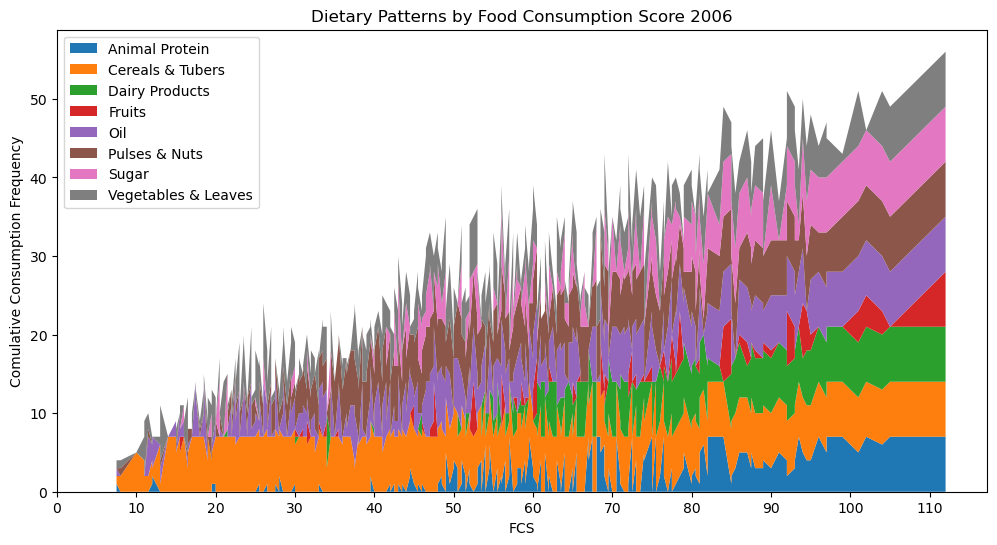

In [56]:
plot_food_consumption(data_fcs, year='2006', save_path='Rwanda/graphs/dp2006.png')

In [57]:
#save the data may be useful later
data_fcs.to_csv(dir_2006+ 'rw_2006_fcs.csv', index=False)

#### Compute HDDS

In [64]:
data_hdds = calculate_hdds(data,food_group_mapping)
data_hdds.head()

14 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,hdds
0,120303105,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,6.0
1,80201303,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0
2,60302903,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
3,121009606,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0
4,30401901,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0


In [59]:
#save the data may be useful later
data_hdds.to_csv(dir_2006+ 'rw_2006_hdds.csv', index=False)

#### Combine the files

In [62]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,year,hhid,province,district,sector,fcs,hdds
0,2006,80102604,Iburengerazuba,Rutsiro,Musasa,7.5,4.0
1,2006,91100802,Amajyaruguru,Burera,Rwerere,8.0,3.0
2,2006,100604202,Amajyaruguru,Gicumbi,Rukomo,10.0,1.0
3,2006,120309807,Iburasirazuba,Ngoma,Jarama,11.0,2.0
4,2006,60211405,Iburengerazuba,Rusizi,Nkanka,11.0,3.0
5,2006,40101201,Amajyepfo,Huye,Ngoma,11.0,3.0
6,2006,90806105,Amajyaruguru,Gakenke,Rusasa,11.0,2.0
7,2006,90802199,Amajyaruguru,Burera,Rugarama,11.5,4.0
8,2006,60304604,Iburengerazuba,Nyamasheke,Kagano,12.0,4.0
9,2006,120309805,Iburasirazuba,Ngoma,Jarama,12.0,3.0


In [68]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2006+'rw_2006_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [69]:
agg_data= calculate_mean(data_merged, ['year','province','district'],['fcs','hdds'])
agg_data.head()

,year,province,district,fcs,hdds,count
0,2006,Amajyaruguru,Burera,34.11,3.71,59
1,2006,Amajyaruguru,Gakenke,42.05,4.15,61
2,2006,Amajyaruguru,Gicumbi,39.73,3.70,66
3,2006,Amajyaruguru,Musanze,37.83,4.05,108
4,2006,Amajyaruguru,Rulindo,44.52,4.54,46


In [71]:
#save the final aggregated dataset
agg_data.to_csv(dir_2006+'rw_2006_final.csv', index=False)

#### Visualize Spatial Distribution

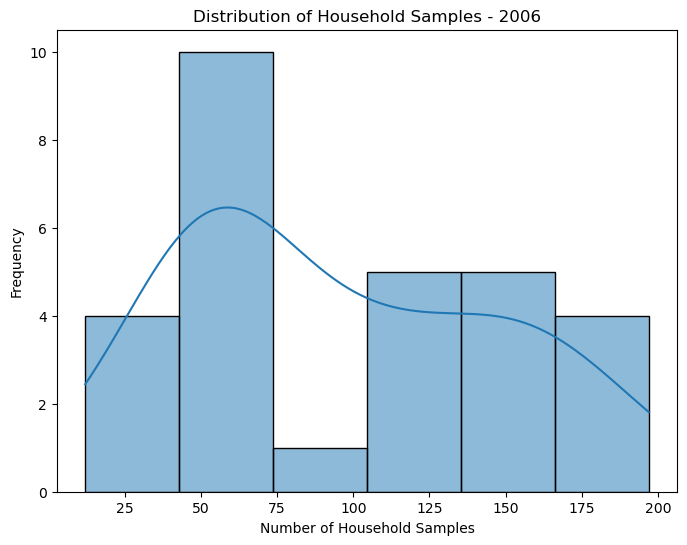

In [70]:
visualize_samples_distribution(agg_data,'2006')

## Comprehensive Food Security and Vulnerability Analysis (CFSVA) - 2012

This dataset is public available on [2012 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/69). The purpose of this Comprehensive Food security and Vulnerability Analysis (CFSVA) is to provide an accurate baseline and understanding of chronic food insecurity and vulnerability conditions.The CFSVA and Nutrition Survey 2012 was designed to produce estimates of food security indicators at district level and covered both urban and rural households. For more discription about this dataset [Click Here](https://microdata.statistics.gov.rw/index.php/catalog/69/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.statistics.gov.rw/index.php/catalog/69/data_dictionary)

#### Loading the data sources

The name of the file we have used in this data set is **cfsvans_2012_household_v01.sav** The file contains data related to Household Questionnaire.This file is in SPSS Statistics Data File Format, therefore we need to change them into csv format for easily manipulation

In [102]:
#define data directory
dir_2012 = 'Rwanda/2012/rwanda_2012_preprocessed_data/'

In [ ]:
'''
#convert cfsvans_2012_household_v01.sav to csv file
o_path= dir_2012 +'cfsvans_2012_household_v01.sav'
u_path = dir_2012 +'cfsvans_2012_household_v01.csv'
sav_to_csv(o_path,u_path) #call the function to convert

'''

In [ ]:
'''
data = read_csv(dir_2012 +'cfsvans_2012_household_v01.csv',header=0, delimiter=',')
df = data
year = 2012

# Arrays containing the column names you want to keep
columns_to_keep = ['hh_id', 'p_code','d_code','s_code','QA904_1','QB904_1','QC904_1','QD904_1',
                   'QE904_1', 'QF904_1', 'QG904_1','QH904_1', 'QI904_1', 'QJ904_1', 'QK904_1','QL904_1',
                   'QM904_1', 'QN904_1', 'QO904_1','QP904_1', 'QQ904_1', 'QR904_1', 'QS904_1','QT904_1',
                   'QU904_1', 'QV904_1','QW904_1', 'QX904_1', 'FCS']
# Output file name
output_file = dir_2012+'rwanda_2012_0.csv'

# Optional: Dictionary for renaming columns
rename_columns = {'hh_id': 'hhid', 'p_code': 'province','d_code': 'district', 's_code': 'sector',
                  'QA904_1': 'maize', 'QB904_1': 'sorghum', 'QC904_1': 'cereals', 'QD904_1': 'cassava',
                  'QE904_1': 'sweet_potato', 'QF904_1': 'roots', 'QG904_1': 'bread', 'QH904_1': 'carrot_tubers',
                  'QI904_1': 'cooking_banana', 'QJ904_1': 'beans_peas', 'QK904_1': 'cassava_leaves', 'QL904_1': 'vegetables',
                  'QM904_1': 'other_vegetables', 'QN904_1': 'ground_nuts', 'QO904_1': 'fruits', 'QP904_1': 'other_fruits',
                  'QQ904_1': 'fish', 'QR904_1': 'organ_meat', 'QS904_1': 'flesh_meat', 'QT904_1': 'eggs',
                  'QU904_1': 'oil', 'QV904_1': 'sugar', 'QW904_1': 'milk', 'QX904_1': 'condiments','FCS':'o_fcs'}

#df, columns_to_keep, output_file,year, rename_columns=None
subset_and_save(df, columns_to_keep, output_file,year,rename_columns)



# Adding province name, district, and sector name and removing the id

# Read the data files

data = read_csv(dir_2012+'rwanda_2012_0.csv',header=0, delimiter=',') #data with new columns

district_data = pd.read_csv(dir_2012+ 'district_name.csv',header=0,delimiter=',')
province_data = pd.read_csv(dir_2012+'province_name.csv',header=0,delimiter=',')
sector_data = pd.read_csv(dir_2012+'sector_name.csv',header=0,delimiter=',')

# Create a mapping dictionary from district_id to district_name
district_mapping = dict(zip(district_data['dist_id'], district_data['dist_name']))

# Create a mapping dictionary from province_id to province_name
province_mapping = dict(zip(province_data['prov_id'], province_data['prev_name']))

# Create a mapping dictionary from sector_id to sector_name
sector_mapping = dict(zip(sector_data['sect_id'], sector_data['sect_name']))

# Add district, province and sector to the data using the mapping dictionary
data['district'] = data['district'].map(district_mapping)
data['province'] = data['province'].map(province_mapping)
data['sector'] = data['sector'].map(sector_mapping)

#save the data
data.to_csv(dir_2012+'rw_2012_food_consumed.csv', index=False)

'''

In [103]:
#load the data to compute fcs
df = read_csv(dir_2012+'rw_2012_food_consumed.csv',header=0, delimiter=',')
df.head()

,year,hhid,province,district,sector,maize,sorghum,cereals,cassava,sweet_potato,...,other_fruits,fish,organ_meat,flesh_meat,eggs,oil,sugar,milk,condiments,o_fcs
0,2012,9746,EAST,BUGESERA,SHYARA,0,0,1,1,1,...,0,0,0,1,0,7,1,0,7,43.0
1,2012,9739,EAST,BUGESERA,SHYARA,0,0,0,2,0,...,0,0,0,2,0,6,1,7,7,66.5
2,2012,9744,EAST,BUGESERA,SHYARA,0,0,0,5,0,...,0,0,0,0,0,0,0,0,3,33.0
3,2012,9738,EAST,BUGESERA,SHYARA,1,0,0,3,0,...,0,0,0,0,0,0,0,0,5,29.0
4,2012,9741,EAST,BUGESERA,SHYARA,1,0,0,5,0,...,0,0,0,0,0,5,2,0,5,38.5


In [104]:
#drop the column assosictaed to location of the household
data = delete_columns(df, ['province','district','sector'])
data.head()

Deleted columns: ['province', 'district', 'sector']


,year,hhid,maize,sorghum,cereals,cassava,sweet_potato,roots,bread,carrot_tubers,...,other_fruits,fish,organ_meat,flesh_meat,eggs,oil,sugar,milk,condiments,o_fcs
0,2012,9746,0,0,1,1,1,0,0,0,...,0,0,0,1,0,7,1,0,7,43.0
1,2012,9739,0,0,0,2,0,0,0,0,...,0,0,0,2,0,6,1,7,7,66.5
2,2012,9744,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,3,33.0
3,2012,9738,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,5,29.0
4,2012,9741,1,0,0,5,0,0,0,0,...,0,0,0,0,0,5,2,0,5,38.5


In [105]:
#read the file containing the reconcilled location of the household 
location =  read_csv(dir_2012+'rw_2012_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,year,hhid,province,district,sector
0,2,2012,9746,Iburasirazuba,Bugesera,Shyara
1,2,2012,9739,Iburasirazuba,Bugesera,Shyara
2,2,2012,9744,Iburasirazuba,Bugesera,Shyara
3,2,2012,9738,Iburasirazuba,Bugesera,Shyara
4,2,2012,9741,Iburasirazuba,Bugesera,Shyara


In [106]:
#check the column names to create the mapping
data.columns

Index(['year', 'hhid', 'maize', 'sorghum', 'cereals', 'cassava',
       'sweet_potato', 'roots', 'bread', 'carrot_tubers', 'cooking_banana',
       'beans_peas', 'cassava_leaves', 'vegetables', 'other_vegetables',
       'ground_nuts', 'fruits', 'other_fruits', 'fish', 'organ_meat',
       'flesh_meat', 'eggs', 'oil', 'sugar', 'milk', 'condiments', 'o_fcs'],
      dtype='object')

In [107]:
# Define the food group mapping based on the weights as defined in the 
food_group_mapping = {
    'maize': 'cereals_tubers',
    'sorghum': 'cereals_tubers',
    'cereals': 'cereals_tubers',
    'cassava': 'cereals_tubers',
    'sweet_potato': 'cereals_tubers',
    'roots': 'cereals_tubers',
    'bread': 'cereals_tubers',
    'carrot_tubers': 'cereals_tubers',
    'cooking_banana': 'cereals_tubers',
    'beans_peas': 'pulses_nuts',
    'vegetables': 'vegetables_leaves',
    'cassava_leaves': 'vegetables_leaves',
    'other_vegetables': 'vegetables_leaves',
    'ground_nuts': 'pulses_nuts',
    'fruits': 'fruits',
    'other_fruits': 'fruits',
    'fish': 'animal_protein',
    'organ_meat': 'animal_protein',
    'flesh_meat': 'animal_protein',
    'eggs': 'animal_protein',
    'oil': 'oil',
    'sugar': 'sugar',
    'milk': 'dairy_products',
    'condiments': 'condiments'
}

#### Compute FCS

In [108]:
#call the function
data_fcs= calculate_fcs(data, food_group_mapping)
data_fcs.head()

2 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,condiments,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,fcs
0,9746,7,3,7,4,7,1,3,0,1,43.0
1,9739,6,0,7,3,7,2,0,7,1,66.5
2,9744,0,0,3,6,7,0,0,0,0,33.0
3,9738,0,0,5,4,7,0,0,0,0,29.0
4,9741,5,0,5,7,7,0,0,0,2,38.5


#### Checking For Dietary Patterns of The Population

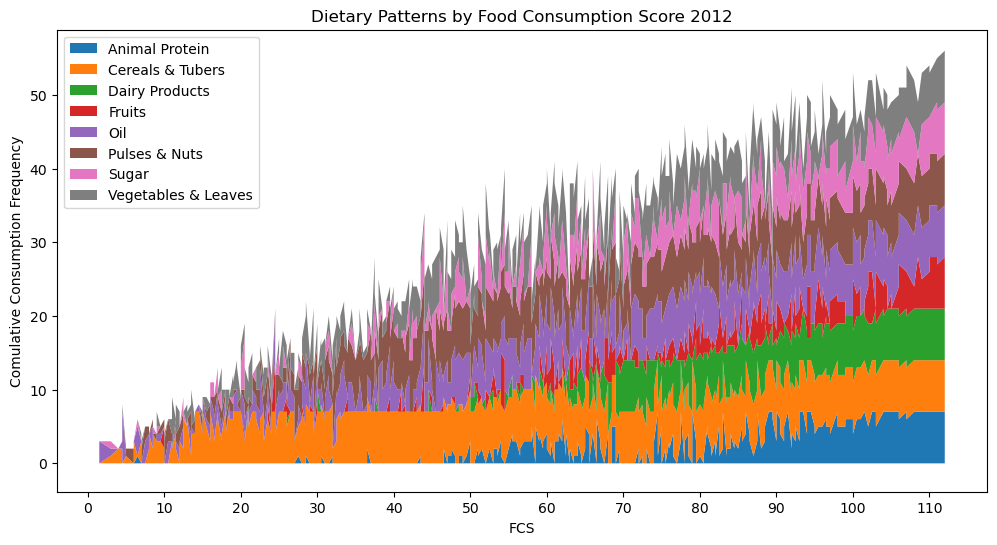

In [109]:
plot_food_consumption(data_fcs, year='2012', save_path='Rwanda/graphs/dp2012.png')

In [110]:
#save the data may be useful later
data_fcs.to_csv(dir_2012+ 'rw_2012_fcs.csv', index=False)

#### Compute HDDS

In [111]:
#call the function
data_hdds= calculate_hdds(data, food_group_mapping)
data_hdds.head()

2 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,condiments,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,hdds
0,9746,1,1,1,1,1,1,1,0,1,8
1,9739,1,0,1,1,1,1,0,1,1,7
2,9744,0,0,1,1,1,0,0,0,0,3
3,9738,0,0,1,1,1,0,0,0,0,3
4,9741,1,0,1,1,1,0,0,0,1,5


In [112]:
#save the data may be useful later
data_hdds.to_csv(dir_2012+ 'rw_2012_hdds.csv', index=False)

#### Combine the files

In [115]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head()

,year,hhid,province,district,sector,fcs,hdds
0,2012,7703,Iburasirazuba,Rwamagana,Musha,1.5,2
1,2012,6235,Amajyaruguru,Gakenke,Gakenke,1.5,2
2,2012,639,Umujyi wa Kigali,Gasabo,Rutunga,3.0,4
3,2012,6897,Amajyaruguru,Burera,Cyanika,4.0,2
4,2012,5046,Iburengerazuba,Ngororero,Muhanda,4.0,2


In [116]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2012+'rw_2012_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [117]:
agg_data= calculate_mean(data_merged, ['year','province','district'],['fcs','hdds'])
agg_data.head()

,year,province,district,fcs,hdds,count
0,2012,Amajyaruguru,Burera,43.29,5.47,250
1,2012,Amajyaruguru,Gakenke,42.42,5.61,250
2,2012,Amajyaruguru,Gicumbi,49.97,5.77,250
3,2012,Amajyaruguru,Musanze,48.76,6.02,250
4,2012,Amajyaruguru,Rulindo,44.75,5.46,250


In [118]:
#save the final data
agg_data.to_csv(dir_2012+'rw_2012_final.csv', index=False)

## Comprehensive Food Security and Vulnerability Analysis (CFSVA) - 2015

This dataset is public available on [2015 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/70). The objective of this Comprehensive Food Security and Vulnerability Analysis 2015 (CFSVA and Nutrition Survey 2012) is to measure the extent and depth of food and nutrition insecurity in Rwanda, analyze trends over time, and integrate the findings with those from the recent 'Fourth Integrated Household Living Conditions Survey' (EICV 4) and 'Rwanda Demographic Health Survey 2014/15 (RDHS 2014/'15). For more discription about this dataset [Click Here](https://microdata.statistics.gov.rw/index.php/catalog/70/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.statistics.gov.rw/index.php/catalog/70/data_dictionary)

#### Loading the data sources

The name of the file we have used in this data set is **cfsva_2015_master_DB_annex.sav** The file contains data related to Household Questionnaire.This file is in SPSS Statistics Data File Format, therefore we need to change them into csv format for easily manipulation

In [119]:
#define data directory
dir_2015 = 'Rwanda/2015/rwanda_2015_preprocessed_data/'

In [ ]:
'''
#convert cfsvans_2012_household_v01.sav to csv file
o_path= dir_2015+'cfsva_2015_master_DB_annex.sav'
u_path = dir_2015+'cfsva_2015_master_DB_annex.csv'
sav_to_csv(o_path,u_path) #call the function to convert

'''

In [ ]:
'''
data = read_csv(dir_2015+'cfsva_2015_master_DB_annex.csv',header=0, delimiter=',')

df = data
year = 2015

# Arrays containing the column names you want to keep
columns_to_keep = ['KEY', 'S0_C_Prov','districts','S0_E_Sect','Starch','Pulses','Meat','Vegetables','Oil',
                   'Fruit', 'Milk', 'Sugar','FCS','HDDS_24h']
# Output file name
output_file = dir_2015+'rwanda_2015.csv'  

# Optional: Dictionary for renaming columns
rename_columns = {'KEY': 'hhid','S0_C_Prov': 'province', 'districts': 'district', 'S0_E_Sect': 'sector',
                  'Starch':'starch','Pulses': 'pulses', 'Meat': 'meat', 'Vegetables': 'vegetables', 'Oil': 'oil',
                  'Fruit': 'fruits', 'Milk': 'milk', 'Sugar': 'sugar', 'HDDS_24h': 'o_HDDS',
                  'FCS': 'o_fcs'}  

#df, columns_to_keep, output_file,year, rename_columns=None
subset_and_save(df, columns_to_keep, output_file,year,rename_columns)

data = read_csv(dir_2015+'rwanda_2015.csv',header=0, delimiter=',')

#modifying the hid value
start_value = 1010
data['new_hid'] = data.index.to_series().apply(lambda x: start_value + x)
data['hhid'] = data['new_hid']
data.drop(columns=['new_hid'], inplace=True)


# Adding province name, district, and sector name and removing the id

# Read the data files

district_data = pd.read_csv(dir_2015+'district_name.csv',header=0,delimiter=',')
province_data = pd.read_csv(dir_2015+'province_name.csv',header=0,delimiter=',')
sector_data = pd.read_csv(dir_2015+'sector_name.csv',header=0,delimiter=',')

# Create a mapping dictionary from district_id to district_name
district_mapping = dict(zip(district_data['dist_id'], district_data['dist_name']))

# Create a mapping dictionary from province_id to province_name
province_mapping = dict(zip(province_data['prov_id'], province_data['prov_name']))

# Create a mapping dictionary from sector_id to sector_name
sector_mapping = dict(zip(sector_data['sect_id'], sector_data['sect_name']))

# Add district, province and sector to the data using the mapping dictionary
data['district'] = data['district'].map(district_mapping)
data['province'] = data['province'].map(province_mapping)
data['sector'] = data['sector'].map(sector_mapping)

#save the data
data.to_csv(dir_2015+'rw_2015_food_consumed.csv', index=False)
'''

In [121]:
df = read_csv(dir_2015+'rw_2015_food_consumed.csv',header=0, delimiter=',')
df.head()

,year,hhid,province,district,sector,starch,pulses,meat,vegetables,oil,fruits,milk,sugar,o_fcs,o_HDDS
0,2015,1010,KIGALI,GASABO,KIMIRONKO,7,7,5,7,7,5,7,7,102.0,9
1,2015,1011,KIGALI,KICUKIRO,KIGARAMA,7,7,7,7,7,6,3,7,95.0,11
2,2015,1012,KIGALI,GASABO,KIMIRONKO,7,7,7,7,7,7,7,7,112.0,11
3,2015,1013,KIGALI,GASABO,GISOZI,7,7,5,7,7,5,4,7,90.0,9
4,2015,1014,KIGALI,GASABO,GISOZI,7,7,7,7,7,7,3,7,96.0,12


In [122]:
#drop the column assosictaed to location of the household
data = delete_columns(df, ['province','district','sector','o_fcs','o_HDDS'])
data.head()

Deleted columns: ['province', 'district', 'sector', 'o_fcs', 'o_HDDS']


,year,hhid,starch,pulses,meat,vegetables,oil,fruits,milk,sugar
0,2015,1010,7,7,5,7,7,5,7,7
1,2015,1011,7,7,7,7,7,6,3,7
2,2015,1012,7,7,7,7,7,7,7,7
3,2015,1013,7,7,5,7,7,5,4,7
4,2015,1014,7,7,7,7,7,7,3,7


In [123]:
#read the file containing the reconcilled location of the household 
location =  read_csv(dir_2015+'rw_2015_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,year,hhid,province,district,sector
0,3,2015,1010,Umujyi wa Kigali,Gasabo,Kimironko
1,3,2015,1011,Umujyi wa Kigali,Kicukiro,Kigarama
2,3,2015,1012,Umujyi wa Kigali,Gasabo,Kimironko
3,3,2015,1013,Umujyi wa Kigali,Gasabo,Gisozi
4,3,2015,1014,Umujyi wa Kigali,Gasabo,Gisozi


In [124]:
data.columns

Index(['year', 'hhid', 'starch', 'pulses', 'meat', 'vegetables', 'oil',
       'fruits', 'milk', 'sugar'],
      dtype='object')

In [125]:
# Define the food group mapping based on the columns
food_group_mapping = {
    'starch': 'cereals_tubers',
    'pulses': 'pulses_nuts',
    'vegetables': 'vegetables_leaves',
    'fruits': 'fruits',
    'meat': 'animal_protein',
    'oil': 'oil',
    'sugar': 'sugar',
    'milk': 'dairy_products'
}

#### Compute FCS

In [126]:
#call the function
data_fcs= calculate_fcs(data, food_group_mapping)
data_fcs.head()

2 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,fcs
0,1010,7,7,7,7,5,5,7,7,102.0
1,1011,7,7,7,7,7,6,3,7,95.0
2,1012,7,7,7,7,7,7,7,7,112.0
3,1013,7,7,7,7,5,5,4,7,90.0
4,1014,7,7,7,7,7,7,3,7,96.0


#### Checking For Dietary Patterns of The Population

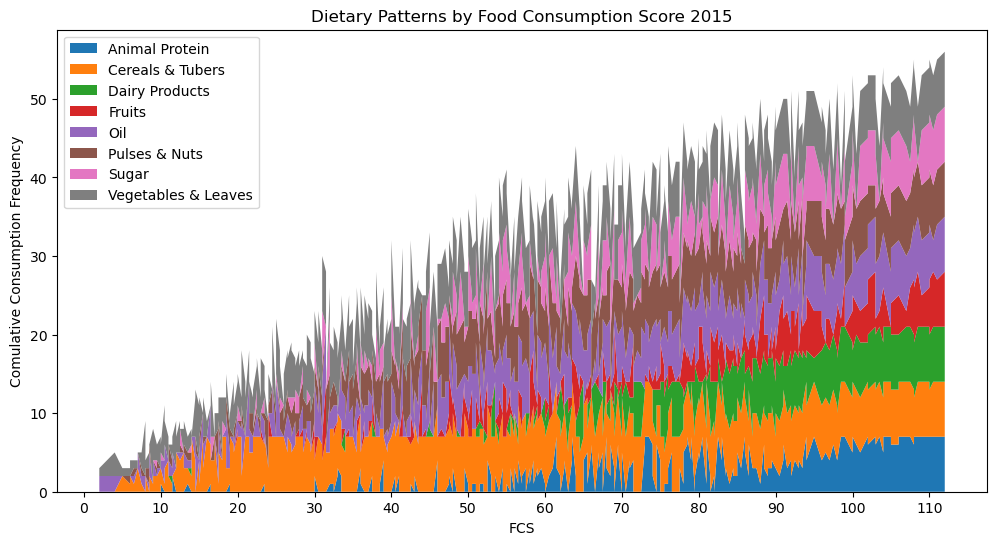

In [127]:
plot_food_consumption(data_fcs, year='2015', save_path='Rwanda/graphs/dp2015.png')

In [128]:
#save the data may be useful later
data_fcs.to_csv(dir_2015+'rw_2015_fcs.csv', index=False)

#### Compute HDDS

In [129]:
#call the function
data_hdds= calculate_hdds(data, food_group_mapping)
data_hdds.head()

2 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,hdds
0,1010,1,1,1,1,1,1,1,1,8
1,1011,1,1,1,1,1,1,1,1,8
2,1012,1,1,1,1,1,1,1,1,8
3,1013,1,1,1,1,1,1,1,1,8
4,1014,1,1,1,1,1,1,1,1,8


In [131]:
#save the data may be useful later
data_hdds.to_csv(dir_2015+'rw_2015_hdds.csv', index=False)

#### Combine the files

In [132]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,year,hhid,province,district,sector,fcs,hdds
0,2015,7986,Umujyi wa Kigali,Kicukiro,Gahanga,2.0,1
1,2015,6563,Iburengerazuba,Nyamasheke,Ruharambuga,2.0,2
2,2015,5105,Amajyepfo,Nyaruguru,Muganza,4.0,2
3,2015,7998,Amajyepfo,Ruhango,Byimana,5.0,2
4,2015,7260,Iburasirazuba,Bugesera,Musenyi,6.0,3
5,2015,3265,Iburasirazuba,Gatsibo,Kabarore,6.0,1
6,2015,4994,Amajyepfo,Nyamagabe,Cyanika,6.0,3
7,2015,3810,Iburengerazuba,Rutsiro,Mushubati,6.0,1
8,2015,2725,Iburengerazuba,Nyamasheke,Macuba,6.0,2
9,2015,8218,Iburasirazuba,Bugesera,Musenyi,6.0,2


In [133]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2015+'rw_2015_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [135]:
agg_data= calculate_mean(data_merged, ['year','province','district'],['fcs','hdds'])
agg_data.head()

,year,province,district,fcs,hdds,count
0,2015,Amajyaruguru,Burera,38.10,4.09,250
1,2015,Amajyaruguru,Gakenke,35.78,4.26,249
2,2015,Amajyaruguru,Gicumbi,48.87,4.87,249
3,2015,Amajyaruguru,Musanze,44.15,5.00,250
4,2015,Amajyaruguru,Rulindo,55.75,5.86,250


In [136]:
#save the final dataset
agg_data.to_csv(dir_2015+'rw_2015_final.csv', index=False)

## Comprehensive Food Security and Vulnerability Analysis (CFSVA) - 2018

This dataset is public available on [2018 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/91). This Comprehensive Food Security and Vulnerability Analysis (CFSVA) 2018 measures the extent and depth of food and nutrition insecurity in Rwanda, observes trends over time, and analyses the socioeconomic and demographic determinants linked to food and nutrition insecurity. For more discription about this dataset [Click Here](https://microdata.statistics.gov.rw/index.php/catalog/91/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.statistics.gov.rw/index.php/catalog/91/data_dictionary)

#### Loading the data sources

The name of the file we have used in this data set is **1_CFSVA18_DB_HouseholdQues_Full_Annex_201904_NISR.sav** The file contains data related to Household Questionnaire.This file is in SPSS Statistics Data File Format, therefore we need to change them into csv format for easily manipulation

In [138]:
#define data directory
dir_2018 = 'Rwanda/2018/rwanda_2018_preprocessed_data/'

In [ ]:
'''
#convert 1_CFSVA18_DB_HouseholdQues_Full_Annex_201904_NISR.sav to csv file
o_path= dir_2018 + '1_CFSVA18_DB_HouseholdQues_Full_Annex_201904_NISR.sav'
u_path = dir_2018 + '1_CFSVA18_DB_HouseholdQues_Full_Annex_201904_NISR.csv'
sav_to_csv(o_path,u_path) #call the function to convert

'''

In [ ]:
'''
data = read_csv(dir_2018+'1_CFSVA18_DB_HouseholdQues_Full_Annex_201904_NISR.csv',header=0, delimiter=',')
df = data
year = 2018

# Arrays containing the column names you want to keep
columns_to_keep = ['PARENT_KEY', 'S0_C_Prov','S0_D_Dist','S0_E_Livezone','Starch','Pulses','Meat','Vegetables','Oil',
                   'Fruit', 'Milk', 'Sugar','FCS']
# Output file name
output_file = dir_2018 + 'rwanda_2018.csv'  

# Optional: Dictionary for renaming columns
rename_columns = {'PARENT_KEY': 'hhid','S0_C_Prov': 'province', 'S0_D_Dist': 'district', 'S0_E_Livezone': 'zone',
                  'Starch': 'starch','Pulses': 'pulses', 'Meat': 'meat', 'Vegetables': 'vegetables', 'Oil': 'oil',
                  'Fruit': 'fruits', 'Milk': 'milk', 'Sugar': 'sugar', 'FCS': 'o_fcs'}  

#df, columns_to_keep, output_file,year, rename_columns=None
subset_and_save(df, columns_to_keep, output_file,year,rename_columns)

data = read_csv(dir_2018 + 'rwanda_2018.csv',header=0, delimiter=',')

#modifying the hid value
start_value = 3010
data['new_hid'] = data.index.to_series().apply(lambda x: start_value + x)
data['hhid'] = data['new_hid']
data.drop(columns=['new_hid'], inplace=True)
data.to_csv('rwanda_2018_0.csv', index=False)

district_data = pd.read_csv(dir_2018+ 'district_name.csv',header=0,delimiter=',')
province_data = pd.read_csv(dir_2018+ 'province_name.csv',header=0,delimiter=',')
zone_data = pd.read_csv(dir_2018+ 'zone_name.csv',header=0,delimiter=',')

# Create a mapping dictionary from district_id to district_name
district_mapping = dict(zip(district_data['dist_id'], district_data['dist_name']))

# Create a mapping dictionary from province_id to province_name
province_mapping = dict(zip(province_data['prov_id'], province_data['prov_name']))

# Create a mapping dictionary from zone_id to zone_name
zone_mapping = dict(zip(zone_data['zone_id'], zone_data['zone_name']))

# Add district, province and sector to the data using the mapping dictionary
data['district'] = data['district'].map(district_mapping)
data['province'] = data['province'].map(province_mapping)
data['zone'] = data['zone'].map(zone_mapping)

#save the data
data.to_csv(dir_2018+'rw_2018_food_consumed.csv', index=False)

'''

In [139]:
df = read_csv(dir_2018+'rw_2018_food_consumed.csv',header=0, delimiter=',')
df.head()

,year,hhid,province,district,zone,starch,pulses,meat,vegetables,oil,fruits,milk,sugar,o_fcs
0,2018,3010,WEST,KARONGI,WEST CONGO-NILE CREST TEA ZONE,7,7,0,7,7,0,0,0,45.5
1,2018,3011,NORTH,RULINDO,"CENTRAL-NORTHERN HIGHLAND IRISH POTATO, BEANS ...",7,7,0,7,7,0,0,0,45.5
2,2018,3012,NORTH,GICUMBI,"CENTRAL-NORTHERN HIGHLAND IRISH POTATO, BEANS ...",4,7,0,0,2,0,0,0,30.0
3,2018,3013,NORTH,GICUMBI,"CENTRAL-NORTHERN HIGHLAND IRISH POTATO, BEANS ...",4,7,0,4,0,0,0,0,33.0
4,2018,3014,NORTH,GICUMBI,"CENTRAL-NORTHERN HIGHLAND IRISH POTATO, BEANS ...",7,7,0,7,7,2,7,7,79.0


In [140]:
#drop the column assosictaed to location of the household
data = delete_columns(df, ['province','district','zone','o_fcs'])
data.head()

Deleted columns: ['province', 'district', 'zone', 'o_fcs']


,year,hhid,starch,pulses,meat,vegetables,oil,fruits,milk,sugar
0,2018,3010,7,7,0,7,7,0,0,0
1,2018,3011,7,7,0,7,7,0,0,0
2,2018,3012,4,7,0,0,2,0,0,0
3,2018,3013,4,7,0,4,0,0,0,0
4,2018,3014,7,7,0,7,7,2,7,7


In [141]:
#read the file containing the reconcilled location of the household 
location =  read_csv(dir_2018+'rw_2018_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,year,hhid,province,district,zone
0,4,2018,3010,Iburengerazuba,Karongi,West Congo-nile Crest Tea Zone
1,4,2018,3011,Amajyaruguru,Rulindo,"Central-northern Highland Irish Potato, Beans ..."
2,4,2018,3012,Amajyaruguru,Gicumbi,"Central-northern Highland Irish Potato, Beans ..."
3,4,2018,3013,Amajyaruguru,Gicumbi,"Central-northern Highland Irish Potato, Beans ..."
4,4,2018,3014,Amajyaruguru,Gicumbi,"Central-northern Highland Irish Potato, Beans ..."


In [142]:
data.columns

Index(['year', 'hhid', 'starch', 'pulses', 'meat', 'vegetables', 'oil',
       'fruits', 'milk', 'sugar'],
      dtype='object')

In [143]:
# Define the food group mapping based on the columns
food_group_mapping = {
    'starch': 'cereals_tubers',
    'pulses': 'pulses_nuts',
    'vegetables': 'vegetables_leaves',
    'fruits': 'fruits',
    'meat': 'animal_protein',
    'oil': 'oil',
    'sugar': 'sugar',
    'milk': 'dairy_products'
}

#### Compute FCS

In [144]:
#call the function
data_fcs= calculate_fcs(data, food_group_mapping)
data_fcs.head()

1 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,fcs
0,3010,7,7,7,7,0,0,0,0,45.5
1,3011,7,7,7,7,0,0,0,0,45.5
2,3012,2,0,4,7,0,0,0,0,30.0
3,3013,0,4,4,7,0,0,0,0,33.0
4,3014,7,7,7,7,0,2,7,7,79.0


#### Checking For Dietary Patterns of The Population

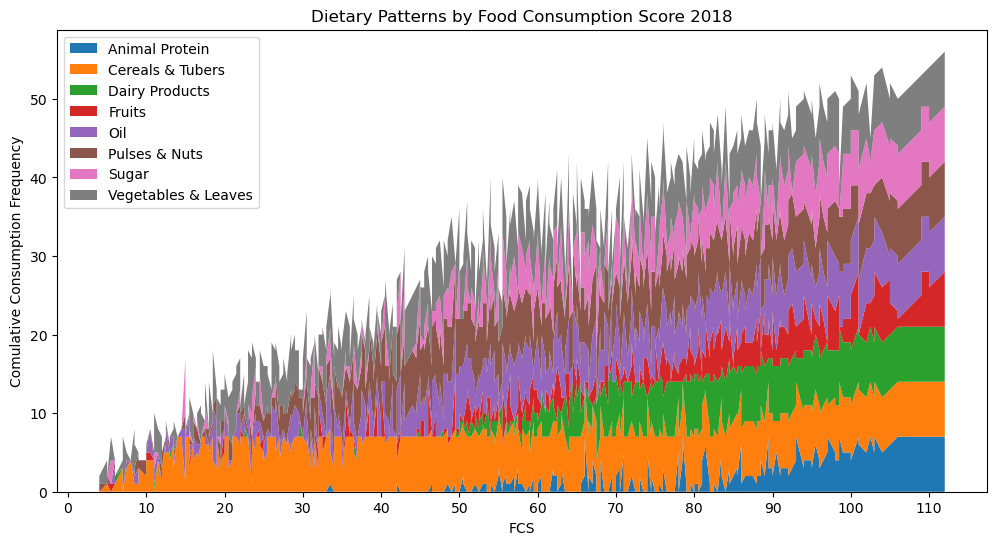

In [145]:
plot_food_consumption(data_fcs, year='2018', save_path='Rwanda/graphs/dp2018.png')

In [146]:
#save the data may be useful later
data_fcs.to_csv(dir_2018+ 'rw_2018_fcs.csv', index=False)

#### Compute HDDS

In [147]:
#call the function
data_hdds= calculate_hdds(data, food_group_mapping)
data_hdds.head()

1 row(s) with all specified columns being 0 have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,hdds
0,3010,1,1,1,1,0,0,0,0,4
1,3011,1,1,1,1,0,0,0,0,4
2,3012,1,0,1,1,0,0,0,0,3
3,3013,0,1,1,1,0,0,0,0,3
4,3014,1,1,1,1,0,1,1,1,7


In [148]:
#save the data may be useful later
data_hdds.to_csv(dir_2018+ 'rw_2018_hdds.csv', index=False)

#### Combine the files

In [149]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,year,hhid,province,district,zone,fcs,hdds
0,2018,11211,Iburengerazuba,Rutsiro,West Congo-nile Crest Tea Zone,4.0,2
1,2018,11227,Iburengerazuba,Rutsiro,West Congo-nile Crest Tea Zone,5.0,2
2,2018,11228,Iburengerazuba,Rutsiro,Lake Kivu Coffee Zone,5.0,2
3,2018,4478,Iburengerazuba,Rutsiro,West Congo-nile Crest Tea Zone,5.5,3
4,2018,12147,Iburengerazuba,Rutsiro,West Congo-nile Crest Tea Zone,6.0,3
5,2018,11229,Iburengerazuba,Rutsiro,West Congo-nile Crest Tea Zone,6.0,2
6,2018,12216,Iburengerazuba,Nyamasheke,Lake Kivu Coffee Zone,7.0,2
7,2018,9382,Amajyaruguru,Rulindo,"Central-northern Highland Irish Potato, Beans ...",7.0,1
8,2018,7898,Iburasirazuba,Kirehe,Southeastern Plateau Banana Zone,7.5,3
9,2018,5828,Iburengerazuba,Rusizi,Lake Kivu Coffee Zone,8.0,1


In [151]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2018+'rw_2018_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [152]:
agg_data= calculate_mean(data_merged, ['year','province','district'],['fcs','hdds'])
agg_data.head()

,year,province,district,fcs,hdds,count
0,2018,Amajyaruguru,Burera,39.12,4.20,323
1,2018,Amajyaruguru,Gakenke,44.14,4.76,327
2,2018,Amajyaruguru,Gicumbi,47.13,5.09,324
3,2018,Amajyaruguru,Musanze,45.63,4.74,329
4,2018,Amajyaruguru,Rulindo,44.65,5.02,323


In [153]:
#save the data may be useful later
agg_data.to_csv(dir_2018 + 'rw_2018_final.csv', index=False)

## Comprehensive Food Security and Vulnerability Analysis (CFSVA) - 2021

This dataset is public available on [2021 - Comprehensive Food Security and Vulnerability Analysis (CFSVA)](https://microdata.statistics.gov.rw/index.php/catalog/106). The purpose of this Comprehensive Food security and Vulnerability Analysis (CFSVA) is to provide an accurate baseline and understanding of chronic food insecurity and vulnerability conditions.The CFSVA and Nutrition Survey 2021 was designed to produce estimates of food security indicators at district level and covered both urban and rural households. For more discription about this dataset [Click Here](https://microdata.statistics.gov.rw/index.php/catalog/106/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.statistics.gov.rw/index.php/catalog/106/data_dictionary)

#### Loading the data sources

The name of the file we have used in this data set is **CFSVA_HH_2021_MASTER_DATASET.dta** The file contains data related to Household Questionnaire.This file is in stata Data File Format, therefore we need to change them into csv format for easily manipulation

In [155]:
#define data directory
dir_2021 = 'Rwanda/2021/rwanda_2021_preprocessed_data/'

In [ ]:
'''
#convert CFSVA_HH_2021_MASTER_DATASET.dta to csv file
o_path= dir_2021+'CFSVA_HH_2021_MASTER_DATASET.dta'
u_path = dir_2021+'CFSVA_HH_2021_MASTER_DATASET.csv'
dta_to_csv(o_path,u_path) #call the function to convert

'''

In [ ]:
'''
data = read_csv(dir_2021+'CFSVA_HH_2021_MASTER_DATASET.csv',header=0, delimiter=',')

df = data
year = 2021

# Arrays containing the column names you want to keep
columns_to_keep = ['S0_B_DATE', 'S0_C_Prov','S0_D_Dist','S0_E_Livezone','Starch','Pulses','Meat','Vegetables','Oil',
                   'Fruit', 'Milk', 'Sugar','FCS']
# Output file name
output_file = dir_2021+'rwanda_2021.csv'  

# Optional: Dictionary for renaming columns
rename_columns = {'S0_B_DATE': 'hhid','S0_C_Prov': 'province', 'S0_D_Dist': 'district','S0_E_Livezone': 'zone',
                  'Starch': 'starch','Pulses': 'pulses', 'Meat': 'meat', 'Vegetables': 'vegetables', 'Oil': 'oil',
                  'Fruit': 'fruits', 'Milk': 'milk', 'Sugar': 'sugar', 'FCS' : 'o_fcs'}  

#df, columns_to_keep, output_file,year, rename_columns=None
subset_and_save(df, columns_to_keep, output_file,year,rename_columns)

#read the data file
data = read_csv(dir_2021+'rwanda_2021.csv',header=0, delimiter=',')


#modifying the hid value
start_value = 41010
data['new_hid'] = data.index.to_series().apply(lambda x: start_value + x)
data['hhid'] = data['new_hid']
data.drop(columns=['new_hid'], inplace=True)
data.to_csv('dir_2021+ 'rw_2021_food_consumed.csv', index=False)
'''

In [156]:
df = read_csv(dir_2021+ 'rw_2021_food_consumed.csv',header=0, delimiter=',')
df.head()

,year,hhid,province,district,zone,starch,pulses,meat,vegetables,oil,fruits,milk,sugar,o_fcs
0,2021,41010,Eastern,Rwamagana,Southeastern Plateau Banana Zone,7,7,3,7,5,5,4,3,79.0
1,2021,41011,Northern,Gakenke,East Congo-Nile Highland Subsistence Farming Zone,7,7,4,4,7,0,1,7,66.0
2,2021,41012,Eastern,Gatsibo,Eastern Plateau Mixed Agriculture Zone,7,7,0,3,5,0,0,2,41.5
3,2021,41013,Western,Rusizi,Lake Kivu Coffee Zone,7,7,0,7,7,0,1,0,49.5
4,2021,41014,Eastern,Kirehe,Southeastern Plateau Banana Zone,7,7,0,7,7,2,0,1,48.0


In [157]:
#drop the column assosictaed to location of the household
data = delete_columns(df, ['province','district','zone','o_fcs'])
data.head()

Deleted columns: ['province', 'district', 'zone', 'o_fcs']


,year,hhid,starch,pulses,meat,vegetables,oil,fruits,milk,sugar
0,2021,41010,7,7,3,7,5,5,4,3
1,2021,41011,7,7,4,4,7,0,1,7
2,2021,41012,7,7,0,3,5,0,0,2
3,2021,41013,7,7,0,7,7,0,1,0
4,2021,41014,7,7,0,7,7,2,0,1


In [158]:
#read the file containing the reconcilled location of the household 
location =  read_csv(dir_2021+'rw_2021_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,year,hhid,province,district,zone
0,5,2021,41010,Iburasirazuba,Rwamagana,Southeastern Plateau Banana Zone
1,5,2021,41011,Amajyaruguru,Gakenke,East Congo-nile Highland Subsistence Farming Zone
2,5,2021,41012,Iburasirazuba,Gatsibo,Eastern Plateau Mixed Agriculture Zone
3,5,2021,41013,Iburengerazuba,Rusizi,Lake Kivu Coffee Zone
4,5,2021,41014,Iburasirazuba,Kirehe,Southeastern Plateau Banana Zone


In [159]:
data.columns

Index(['year', 'hhid', 'starch', 'pulses', 'meat', 'vegetables', 'oil',
       'fruits', 'milk', 'sugar'],
      dtype='object')

In [160]:
# Define the food group mapping based on the columns
food_group_mapping = {
    'starch': 'cereals_tubers',
    'pulses': 'pulses_nuts',
    'vegetables': 'vegetables_leaves',
    'fruits': 'fruits',
    'meat': 'animal_protein',
    'oil': 'oil',
    'sugar': 'sugar',
    'milk': 'dairy_products'
}

#### Compute FCS

In [161]:
#call the function
data_fcs= calculate_fcs(data, food_group_mapping)
data_fcs.head()

No rows have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,fcs
0,41010,5,7,7,7,3,5,4,3,79.0
1,41011,7,4,7,7,4,0,1,7,66.0
2,41012,5,3,7,7,0,0,0,2,41.5
3,41013,7,7,7,7,0,0,1,0,49.5
4,41014,7,7,7,7,0,2,0,1,48.0


#### Checking For Dietary Patterns of The Population

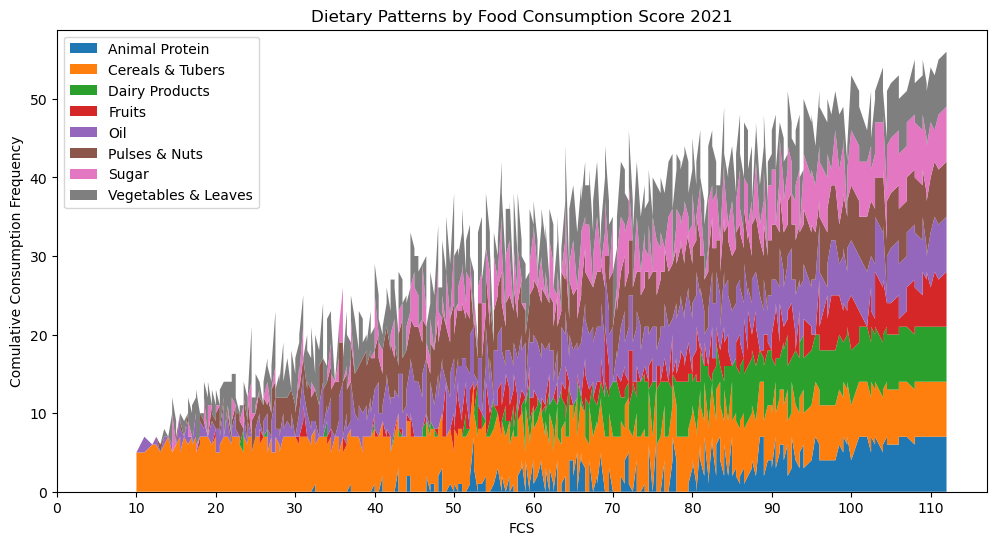

In [162]:
plot_food_consumption(data_fcs, year='2021', save_path='Rwanda/graphs/dp2021.png')

In [163]:
#save the final dataset may be useful later
data_fcs.to_csv(dir_2021+ 'rw_2021_fcs.csv', index=False)

#### Compute HDDS

In [164]:
#call the function
data_hdds= calculate_hdds(data, food_group_mapping)
data_hdds.head()

No rows have been deleted.


,hhid,oil,vegetables_leaves,cereals_tubers,pulses_nuts,animal_protein,fruits,dairy_products,sugar,hdds
0,41010,1,1,1,1,1,1,1,1,8
1,41011,1,1,1,1,1,0,1,1,7
2,41012,1,1,1,1,0,0,0,1,5
3,41013,1,1,1,1,0,0,1,0,5
4,41014,1,1,1,1,0,1,0,1,6


In [165]:
#save the final dataset may be useful later
data_hdds.to_csv(dir_2021+ 'rw_2021_hdds.csv', index=False)

#### Combine the files

In [166]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,year,hhid,province,district,zone,fcs,hdds
0,2021,45912,Amajyepfo,Huye,East Congo-nile Highland Subsistence Farming Zone,10.0,1
1,2021,46169,Iburengerazuba,Ngororero,West Congo-nile Crest Tea Zone,11.0,2
2,2021,47075,Amajyepfo,Huye,East Congo-nile Highland Subsistence Farming Zone,12.0,1
3,2021,46028,Iburasirazuba,Gatsibo,Eastern Plateau Mixed Agriculture Zone,12.0,1
4,2021,44694,Iburengerazuba,Ngororero,East Congo-nile Highland Subsistence Farming Zone,12.5,2
5,2021,47008,Amajyepfo,Huye,East Congo-nile Highland Subsistence Farming Zone,13.0,2
6,2021,48138,Iburengerazuba,Rutsiro,West Congo-nile Crest Tea Zone,13.0,2
7,2021,48280,Iburasirazuba,Ngoma,Southeastern Plateau Banana Zone,13.0,2
8,2021,48058,Iburasirazuba,Gatsibo,Eastern Plateau Mixed Agriculture Zone,13.0,2
9,2021,48623,Iburasirazuba,Gatsibo,"Central-northern Highland Irish Potato, Beans ...",13.0,3


In [167]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2021+'rw_2021_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [168]:
agg_data= calculate_mean(data_merged, ['year','province','district'],['fcs','hdds'])
agg_data.head()

,year,province,district,fcs,hdds,count
0,2021,Amajyaruguru,Burera,35.17,3.90,300
1,2021,Amajyaruguru,Gakenke,47.08,4.91,300
2,2021,Amajyaruguru,Gicumbi,51.96,5.18,300
3,2021,Amajyaruguru,Musanze,45.61,5.33,300
4,2021,Amajyaruguru,Rulindo,47.14,5.67,300


In [169]:
#save the final dataset 
agg_data.to_csv(dir_2021+ 'rw_2021_final.csv', index=False)